## Intro fig et qualtitatif 

In [1]:
import os
import torchvision.transforms as transforms
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from lscaleuq.models.clip import load as load_clip
from lscaleuq.models.clip import tokenize as clip_tokenize
from lscaleuq.models import ConfidNetVLMAttention
from lscaleuq.dataset_uq.utils import ConvertImageToRGB  


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clip_model, _ = load_clip("ViT-B/32")
clip_model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [3]:

confidnet = ConfidNetVLMAttention(
                                        concat=True,
                                        identity_init=True,
                                        n_iter_freeze_proj=1000,
                                        keep_frozen=True,
                                        use_predicted_caption=False,
                                        use_attention=False,
                                        )

uqvlm = ConfidNetVLMAttention(
                                        concat=True,
                                        identity_init=True,
                                        n_iter_freeze_proj=1000,
                                        keep_frozen=True,
                                        use_predicted_caption=True,
                                        use_attention=True,
                                        )

logit_scale = uqvlm.logit_scale

In [4]:
confidnet_path = '/users/k/karmimy/These/large_scale_uq/weights/confidnet_imgnet.ckpt'
uqvlm_path = '/users/k/karmimy/These/large_scale_uq/weights/uq_vlm_imgnet.ckpt'

In [5]:
confidnet.load_state_dict(torch.load(confidnet_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')['state_dict'])
uqvlm.load_state_dict(torch.load(uqvlm_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')['state_dict'])
confidnet.to(device)
uqvlm.to(device)
confidnet.eval()
uqvlm.eval()

/tmp/ipykernel_53537/360048097.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  confidnet.load_state_dict(torch.load(confidnet_path, map_location='cuda' if torch.cuda.is_

ConfidNetVLMAttention(
  (activation_fn): ReLU()
  (mlp): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (in_proj_v): Linear(in_features=512, out_features=512, bias=False)
  (in_proj_t): Linear(in_features=512, out_features=512, bias=False)
)

### Qualitative res

In [6]:

folder_image = '/users/k/karmimy/These/large_scale_uq/images'

val_transforms = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),  # interpolation=3 correspond à BICUBIC
    transforms.CenterCrop(224),
    ConvertImageToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])

template = "A photo of a {}."

def load_input(image_name,classes_names):

    image_path = os.path.join(folder_image, image_name)
    
    text_inputs = clip_tokenize([template.format(name) for name in classes_names]).to(device)
    image = Image.open(image_path)
    image_input = val_transforms(image).unsqueeze(0).to(device)
    return image, image_input, text_inputs

In [7]:
image, image_input, text_inputs = load_input('ChienLoup.jpg',['dog','wolf'])

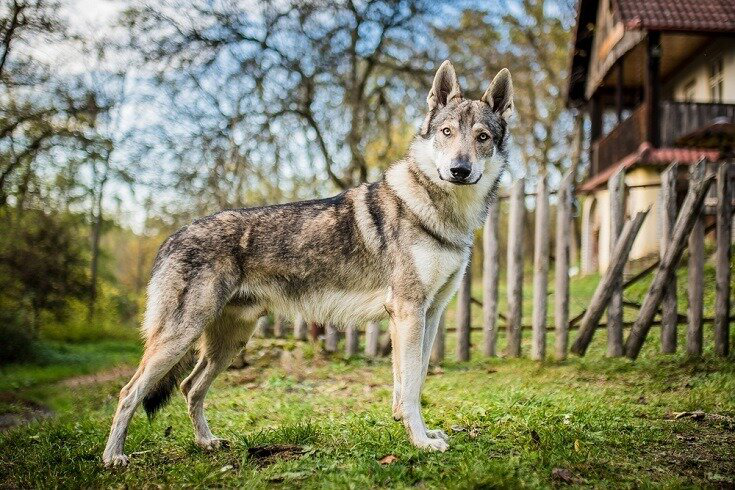

In [8]:
image

In [9]:
with torch.no_grad():
    text_feats = clip_model.encode_text(text_inputs)
    text_feats /= text_feats.norm(dim=-1, keepdim=True)
    visual_feats = clip_model.encode_image(image_input)
    visual_feats /= visual_feats.norm(dim=-1, keepdim=True)

    probs = torch.softmax(logit_scale * visual_feats @ text_feats.t(), dim=-1)
probs

tensor([[0.0453, 0.9546]], device='cuda:0', dtype=torch.float16)

In [10]:

with torch.autocast(device_type='cuda'):
    confidnet_score = confidnet(visual_feats,text_feats)
    uqvlm_score = uqvlm(visual_feats,text_feats)
    mcm_score = probs.max(dim=-1).values


In [11]:
print(f"ConfidNet score: {confidnet_score.item()}")
print(f"UQ-VLM score: {uqvlm_score.item()}")
print(f"MCM score: {mcm_score.item()}")

ConfidNet score: -0.86474609375
UQ-VLM score: 1.1650390625
MCM score: 0.95458984375


### Calcul du seuil sur imagenet

In [12]:
from lscaleuq.dataset_uq import ImageNetDataset
import lscaleuq.lib as lib
from torch.utils.data import DataLoader

In [13]:
NB_IMAGES = 100000
MCM_TRESHOLD_FPR = 0.994140625
CONFIDNET_TRESHOLD_FPR = 4.51171875
UQVLM_TRESHOLD_FPR = 6.640625
need_treshold = False
dts_train = ImageNetDataset('/local/DEEPLEARNING/LargeScaleUQ/ImageNet',split='train',transform=val_transforms)
dts_val = ImageNetDataset('/local/DEEPLEARNING/LargeScaleUQ/ImageNet',split='val',transform=val_transforms)

In [14]:
dataloader_train = DataLoader(dts_train, batch_size=512, shuffle=True, num_workers=4)
dataloader_val = DataLoader(dts_val, batch_size=1024, shuffle=False, num_workers=4)

### Compute treshold FPR for imagenet (MCM,Confidnet and UQVLM)

In [15]:

if need_treshold:
    confidnet_success = []
    confidnet_failure = []
    uqvlm_success = []
    uqvlm_failure = []
    missclassifieds = []
    tcps_success = []
    tcps_failure = []
    mcps_success = []
    mcps_failure = []
    total_iter = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader_train):
            if total_iter >= NB_IMAGES:
                break
            total_iter += 512
            images = batch["image"]
            labels = batch["target"].to(device)
            visual_feats = clip_model.encode_image(images.to(device))
            visual_feats /= visual_feats.norm(dim=-1, keepdim=True)
            class_names = dataloader_val.dataset.class_names
            class_names = clip_tokenize([template.format(name) for name in class_names])
            text_feats = clip_model.encode_text(class_names.to(device))
            text_feats /= text_feats.norm(dim=-1, keepdim=True)

            probs = torch.softmax(logit_scale * visual_feats @ text_feats.t(), dim=-1)
            with torch.autocast(device_type='cuda'):
                confidnet_scores = confidnet(visual_feats, text_feats).squeeze(-1)
                uqvlm_scores = uqvlm(visual_feats, text_feats).squeeze(-1)

            missclassified = labels != probs.argmax(dim=-1)

            tcps = probs[torch.arange(labels.size(0)), labels]
            mcps = probs.max(dim=-1).values

            confidnet_success.append(confidnet_scores[~missclassified])
            confidnet_failure.append(confidnet_scores[missclassified])
            uqvlm_success.append(uqvlm_scores[~missclassified])
            uqvlm_failure.append(uqvlm_scores[missclassified])
            missclassifieds.append(missclassified)

            tcps_success.append(tcps[~missclassified])
            tcps_failure.append(tcps[missclassified])
            mcps_success.append(mcps[~missclassified])
            mcps_failure.append(mcps[missclassified])

        missclassifieds = torch.cat(missclassifieds).cpu().numpy()
        confidnet_success = torch.cat(confidnet_success).cpu().numpy()
        confidnet_failure = torch.cat(confidnet_failure).cpu().numpy()
        uqvlm_success = torch.cat(confidnet_success).cpu().numpy()
        uqvlm_failure = torch.cat(confidnet_failure).cpu().numpy()
        tcps_success = torch.cat(tcps_success).float().cpu().numpy()
        tcps_failure = torch.cat(tcps_failure).float().cpu().numpy()
        mcps_success = torch.cat(mcps_success).float().cpu().numpy()
        mcps_failure = torch.cat(mcps_failure).float().cpu().numpy()

### Val Image

In [23]:
confidnet_success = []
confidnet_failure = []
uqvlm_success = []
uqvlm_failure = []
missclassifieds = []
tcps_success = []
tcps_failure = []
mcps_success = []
mcps_failure = []
total_iter = 0
with torch.no_grad():
    class_names = dataloader_val.dataset.class_names
    class_names = clip_tokenize([template.format(name) for name in class_names])
    for i, batch in enumerate(dataloader_val):
        images = batch["image"]
        labels = batch["target"].to(device)
        visual_feats = clip_model.encode_image(images.to(device))
        visual_feats /= visual_feats.norm(dim=-1, keepdim=True)
        
        text_feats = clip_model.encode_text(class_names.to(device))
        text_feats /= text_feats.norm(dim=-1, keepdim=True)

        probs = torch.softmax(logit_scale * visual_feats @ text_feats.t(), dim=-1)
        with torch.autocast(device_type='cuda'):
            confidnet_scores = confidnet(visual_feats, text_feats).squeeze(-1)
            uqvlm_scores = uqvlm(visual_feats, text_feats).squeeze(-1)

        missclassified = labels != probs.argmax(dim=-1)

        tcps = probs[torch.arange(labels.size(0)), labels]
        mcps = probs.max(dim=-1).values

        confidnet_success.append(confidnet_scores[~missclassified])
        confidnet_failure.append(confidnet_scores[missclassified])
        uqvlm_success.append(uqvlm_scores[~missclassified])
        uqvlm_failure.append(uqvlm_scores[missclassified])
        missclassifieds.append(missclassified)

        tcps_success.append(tcps[~missclassified])
        tcps_failure.append(tcps[missclassified])
        mcps_success.append(mcps[~missclassified])
        mcps_failure.append(mcps[missclassified])
    
    missclassifieds = torch.cat(missclassifieds).cpu().numpy()
    confidnet_success = torch.sigmoid(torch.cat(confidnet_success)).cpu().numpy()
    confidnet_failure = torch.sigmoid(torch.cat(confidnet_failure)).cpu().numpy()
    uqvlm_success = torch.sigmoid(torch.cat(uqvlm_success)).cpu().numpy()
    uqvlm_failure = torch.sigmoid(torch.cat(uqvlm_failure)).cpu().numpy()
    tcps_success = torch.cat(tcps_success).float().cpu().numpy()
    tcps_failure = torch.cat(tcps_failure).float().cpu().numpy()
    mcps_success = torch.cat(mcps_success).float().cpu().numpy()
    mcps_failure = torch.cat(mcps_failure).float().cpu().numpy()

    fpr_confidnet = lib.get_fpr(confidnet_success, confidnet_failure)
    auc_confidnet = lib.get_auroc(confidnet_success, confidnet_failure)

    fpr_uqvlm = lib.get_fpr(uqvlm_success, uqvlm_failure)
    auc_uqvlm = lib.get_auroc(uqvlm_success, uqvlm_failure)

    fpr_mcm = lib.get_fpr(mcps_success, mcps_failure)
    auc_mcm = lib.get_auroc(mcps_success, mcps_failure)


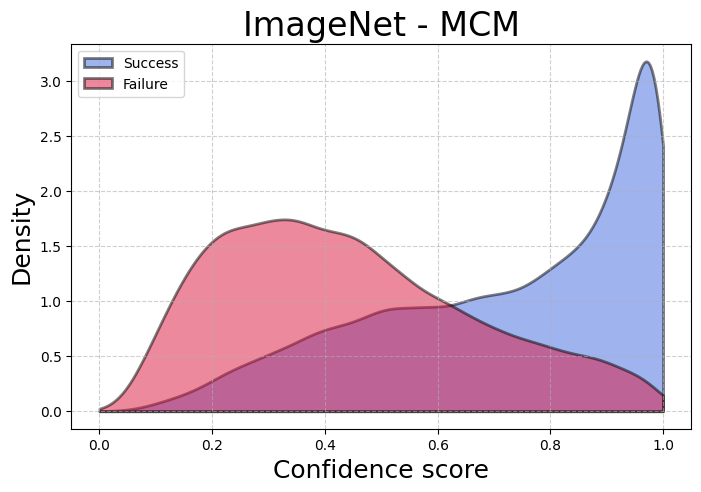

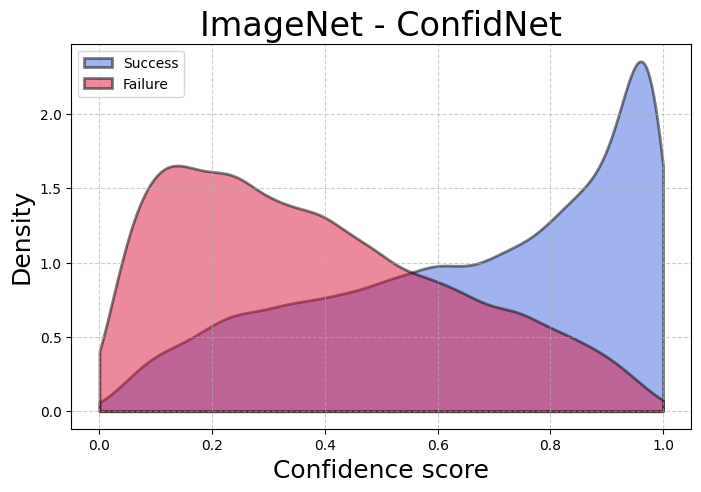

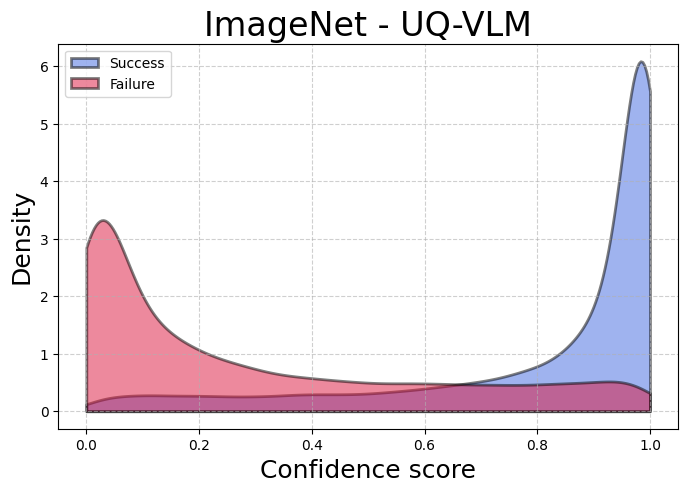

In [24]:


def plot_gaussian_distributions(success, failure,method="MCM"):
    """
    Trace deux distributions gaussiennes basées sur les données en entrée.
    
    Paramètres :
        success (array-like): Données correspondant aux succès.
        failure (array-like): Données correspondant aux échecs.
    """
    plt.figure(figsize=(8, 5))
    
    # Définir les couleurs et styles
    success_color = "royalblue"
    failure_color = "crimson"
    edge_color = "black"

    # Estimation de la densité
    success_kde = gaussian_kde(success)
    failure_kde = gaussian_kde(failure)

    # Créer un axe de valeurs pour le plot
    x_min = 0
    x_max = 1
    x_vals = np.linspace(x_min, x_max, 300)

    # Calcul des densités
    success_density = success_kde(x_vals)
    failure_density = failure_kde(x_vals)

    # Tracer les courbes avec remplissage
    plt.fill_between(x_vals, success_density, color=success_color, alpha=0.5, edgecolor=edge_color, linewidth=2, label="Success")
    plt.fill_between(x_vals, failure_density, color=failure_color, alpha=0.5, edgecolor=edge_color, linewidth=2, label="Failure")

    # Affichage et mise en forme
    plt.xlabel("Confidence score", fontsize=18)
    plt.ylabel("Density", fontsize=18)
    plt.title("ImageNet - {}".format(method), fontsize=24)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Exemple d'utilisation avec uqvlm_success et uqvlm_failure
plot_gaussian_distributions(mcps_success, mcps_failure,"MCM")
plot_gaussian_distributions(confidnet_success, confidnet_failure,"ConfidNet")
plot_gaussian_distributions(uqvlm_success, uqvlm_failure,"UQ-VLM")